In [1]:
import h5py
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import yaml

plt.rcParams["figure.dpi"] = 200
# reduced for quick viewing
# plt.rcParams["figure.dpi"] = 400
plt.rcParams["text.usetex"] = False
# disabled due to missing font in the texlive on the Nikhef clusters
# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.constrained_layout.use"] = True

In [2]:
from hit_evaluate import load_events
from plot_utils import binned, profile_plot

In [3]:
hdf_dir = "/data/atlas/users/slin/myHepattn/hepattn/src/hepattn/experiments/trackml/logs/HC-v3_20250818-T211321/ckpts/epoch=029-val_loss=0.34545_test_eval.h5"

In [4]:
f = h5py.File(hdf_dir, "r")
for key in f.keys():
    print("Key: %s  \tType: %s" % (key, type(f[key])))

Key: 29800  	Type: <class 'h5py._hl.group.Group'>
Key: 29801  	Type: <class 'h5py._hl.group.Group'>
Key: 29802  	Type: <class 'h5py._hl.group.Group'>
Key: 29803  	Type: <class 'h5py._hl.group.Group'>
Key: 29804  	Type: <class 'h5py._hl.group.Group'>
Key: 29805  	Type: <class 'h5py._hl.group.Group'>
Key: 29806  	Type: <class 'h5py._hl.group.Group'>
Key: 29807  	Type: <class 'h5py._hl.group.Group'>
Key: 29808  	Type: <class 'h5py._hl.group.Group'>
Key: 29809  	Type: <class 'h5py._hl.group.Group'>
Key: 29810  	Type: <class 'h5py._hl.group.Group'>
Key: 29811  	Type: <class 'h5py._hl.group.Group'>
Key: 29812  	Type: <class 'h5py._hl.group.Group'>
Key: 29813  	Type: <class 'h5py._hl.group.Group'>
Key: 29814  	Type: <class 'h5py._hl.group.Group'>
Key: 29815  	Type: <class 'h5py._hl.group.Group'>
Key: 29816  	Type: <class 'h5py._hl.group.Group'>
Key: 29817  	Type: <class 'h5py._hl.group.Group'>
Key: 29818  	Type: <class 'h5py._hl.group.Group'>
Key: 29819  	Type: <class 'h5py._hl.group.Group'>


In [5]:
group_key = list(f.keys())[2]
k = list(f[group_key])
for j in k:
    print(j)
    print("\t", f[group_key][j].keys())

inputs
	 <KeysViewHDF5 ['hit_charge_frac', 'hit_eta', 'hit_geta', 'hit_gphi', 'hit_leta', 'hit_lphi', 'hit_lx', 'hit_ly', 'hit_lz', 'hit_phi', 'hit_r', 'hit_s', 'hit_u', 'hit_v', 'hit_valid', 'hit_x', 'hit_y', 'hit_z']>
outputs
	 <KeysViewHDF5 ['final']>
preds
	 <KeysViewHDF5 ['final']>
targets
	 <KeysViewHDF5 ['hit_on_valid_particle', 'hit_valid', 'particle_hit_valid', 'particle_pt', 'particle_valid', 'sample_id']>


# Evaluation file structure

## `inputs` group

In [6]:
print("\ninputs")
print("\t", list(f[group_key]["inputs"]))

print("\n============================")

print("\ninputs/hit_eta")
print("\t", list(f[group_key]["inputs"]["hit_eta"]))


inputs
	 ['hit_charge_frac', 'hit_eta', 'hit_geta', 'hit_gphi', 'hit_leta', 'hit_lphi', 'hit_lx', 'hit_ly', 'hit_lz', 'hit_phi', 'hit_r', 'hit_s', 'hit_u', 'hit_v', 'hit_valid', 'hit_x', 'hit_y', 'hit_z']


inputs/hit_eta
	 [array([-3.416, -3.783, -3.86 , ...,  3.281,  3.14 ,  3.025],
      shape=(60557,), dtype=float16)]


## `outputs` group

In [7]:
print("\noutputs/final/")
print("\t", list(f[group_key]["outputs"]["final"]))

print("\n============================")

print("\noutputs/final/hit_filter/")
print("\t", list(f[group_key]["outputs"]["final"]["hit_filter"]))
print("\noutputs/final/hit_filter/hit_logit")
print("\t", list(f[group_key]["outputs"]["final"]["hit_filter"]["hit_logit"]))




outputs/final/
	 ['hit_filter']


outputs/final/hit_filter/
	 ['hit_logit']

outputs/final/hit_filter/hit_logit
	 [array([ -6.812,  10.625,   5.78 , ..., -11.56 ,  -6.47 , -12.625],
      shape=(60557,), dtype=float16)]


## `preds` group

In [8]:
print("\npreds/final/")
print("\t", list(f[group_key]["preds"]["final"]))

print("\n============================")

print("\npreds/final/hit_filter/")
print("\t", list(f[group_key]["preds"]["final"]["hit_filter"]))
print("\npreds/final/hit_filter/hit_on_valid_particle")
print("\t", list(f[group_key]["preds"]["final"]["hit_filter"]["hit_on_valid_particle"]))



preds/final/
	 ['hit_filter']


preds/final/hit_filter/
	 ['hit_on_valid_particle']

preds/final/hit_filter/hit_on_valid_particle
	 [array([False,  True,  True, ..., False, False, False], shape=(60557,))]


## `targets` group

In [9]:
print("\ntargets/")
print("\t", list(f[group_key]["targets"]))

print("\n============================")

print("\ntargets/hit_on_valid_particle")
print("\t", list(f[group_key]["targets"]["hit_on_valid_particle"]))
print("\ntargets/hit_valid")
print("\t", list(f[group_key]["targets"]["hit_valid"]))
print("\ntargets/particle_hit_valid")
print("\t", list(f[group_key]["targets"]["particle_hit_valid"]))
print("\ntargets/particle_pt")
print("\t", list(f[group_key]["targets"]["particle_pt"]))
print("\ntargets/particle_valid")
print("\t", list(f[group_key]["targets"]["particle_valid"]))
print("\ntargets/sample_id")
print("\t", list(f[group_key]["targets"]["sample_id"]))


targets/
	 ['hit_on_valid_particle', 'hit_valid', 'particle_hit_valid', 'particle_pt', 'particle_valid', 'sample_id']


targets/hit_on_valid_particle
	 [array([False,  True,  True, ..., False, False, False], shape=(60557,))]

targets/hit_valid
	 [array([ True,  True,  True, ...,  True,  True,  True], shape=(60557,))]

targets/particle_hit_valid
	 [array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(3000, 60557))]

targets/particle_pt
	 [array([2.3445141 , 0.90341383, 1.0691355 , ...,        nan,        nan,
              nan], shape=(3000,), dtype=float32)]

targets/particle_valid
	 [array([ True,  True,  True, ..., False, False, False], shape=(3000,))]

targets/sample_id
	 [np.in

# Plot parameters

In [10]:
training_colours = {
    "600 MeV": "mediumvioletred",
    "750 MeV": "cornflowerblue",
    # "1 GeV": "mediumseagreen", # |eta| < 2.5
    "0.9 GeV": "mediumseagreen",  # |eta| < 4.0
}

qty_bins = {
    "pt": np.array([0.6, 0.75, 1.0, 1.5, 2, 3, 4, 6, 10]),
    # "eta": np.array([-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]),
    "eta": np.array([-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]),
    "phi": np.array([-3.14, -2.36, -1.57, -0.79, 0, 0.79, 1.57, 2.36, 3.14]),
    "vz": np.array([-100, -50, -20, -10, 0, 10, 20, 50, 100]),
}

qty_symbols = {"pt": "p_\\mathrm{T}", "eta": "\\eta", "phi": "\\phi", "vz": "v_z"}
qty_units = {"pt": "[GeV]", "eta": "", "phi": "", "vz": "[mm]"}

## Retrieve filtering model configuration

In [11]:
with open("/data/atlas/users/slin/myHepattn/hepattn/src/hepattn/experiments/trackml/configs/filtering.yaml", "r") as f:
    fconfig= yaml.safe_load(f)

filter_params = ["particle_min_pt", "particle_max_abs_eta"]

print("name: "+fconfig["name"])
for i in filter_params:
    print("> "+i+"\t: ", fconfig["data"][i])
    
filtering_configs = {
    "0.9 GeV": fconfig
}

filtering_fnames = {
    "0.9 GeV": "/data/atlas/users/slin/myHepattn/hepattn/src/hepattn/experiments/trackml/logs/HC-v3_20250818-T211321/ckpts/epoch=029-val_loss=0.34545_test_eval.h5"
}
filter_threshold = filtering_configs["0.9 GeV"]["model"]["model"]["init_args"]["tasks"]["init_args"]["modules"][0]["init_args"]["threshold"]
print("> threshold\t\t: ", filter_threshold)
filter_inputs = ["hits_"+filtering_configs["0.9 GeV"]["data"]["inputs"]["hit"][i] for i in range(len(filtering_configs["0.9 GeV"]["data"]["inputs"]["hit"]))]

print("> inputs: ", filter_inputs)

name: HC-v3
> particle_min_pt	:  0.9
> particle_max_abs_eta	:  4.0
> threshold		:  0.1
> inputs:  ['hits_x', 'hits_y', 'hits_z', 'hits_r', 'hits_s', 'hits_eta', 'hits_phi', 'hits_u', 'hits_v', 'hits_charge_frac', 'hits_leta', 'hits_lphi', 'hits_lx', 'hits_ly', 'hits_lz', 'hits_geta', 'hits_gphi']


In [12]:
%%time
filtering_results = {}
num_events=None
for name, fname in filtering_fnames.items():
    filtering_results[name] = load_events(fname, num_events=num_events, write_inputs=None)

loaded event #29800
loaded event #29801
loaded event #29802
loaded event #29803
loaded event #29804
loaded event #29805
loaded event #29806
loaded event #29807
loaded event #29808
loaded event #29809
loaded event #29810
loaded event #29811
loaded event #29812
loaded event #29813
loaded event #29814
loaded event #29815
loaded event #29816
loaded event #29817
loaded event #29818
loaded event #29819
loaded event #29820
loaded event #29821
loaded event #29822
loaded event #29823
loaded event #29824
loaded event #29825
loaded event #29826
loaded event #29827
loaded event #29828
loaded event #29829
loaded event #29830
loaded event #29831
loaded event #29832
loaded event #29833
loaded event #29834
loaded event #29835
loaded event #29836
loaded event #29837
loaded event #29838
loaded event #29839
loaded event #29840
loaded event #29841
loaded event #29842
loaded event #29843
loaded event #29844
loaded event #29845
loaded event #29846
loaded event #29847
loaded event #29848
loaded event #29849


## Plotting metrics

### Discriminant

0.0 1.0


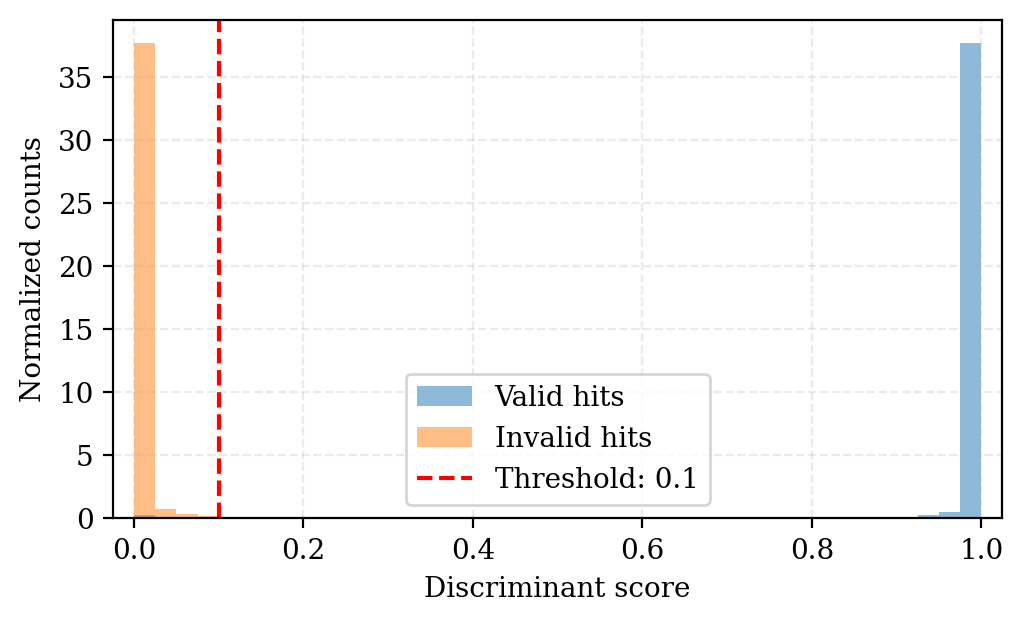

In [13]:
for name, (hits, targets, parts, metrics) in filtering_results.items():
    fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
    ax.hist(hits["score_sigmoid"][targets["hit_on_valid_particle"]], 
            range=[0,1], bins=40, density=True,
            color="C0", alpha=0.5, 
            label="Valid hits"
           )
    ax.hist(hits["score_sigmoid"][~targets["hit_on_valid_particle"]], 
            range=[0,1], bins=40, density=True,
            color="C1", alpha=0.5,
            label="Invalid hits"
           )
    ax.axvline(filter_threshold,
               color="r", ls="dashed", label="Threshold: %.1f"%(filter_threshold))
    print(hits["score_sigmoid"].min(), hits["score_sigmoid"].max())
    
ax.set_xlabel("Discriminant score")
ax.set_ylabel("Normalized counts")
ax.set_xlim(-0.025,1.025)
ax.grid(which="both")
ax.grid(zorder=0, alpha=0.25, linestyle="--")
ax.grid(zorder=0, alpha=0.25, linestyle="--")
ax.legend()

### Receiver operating characteristic

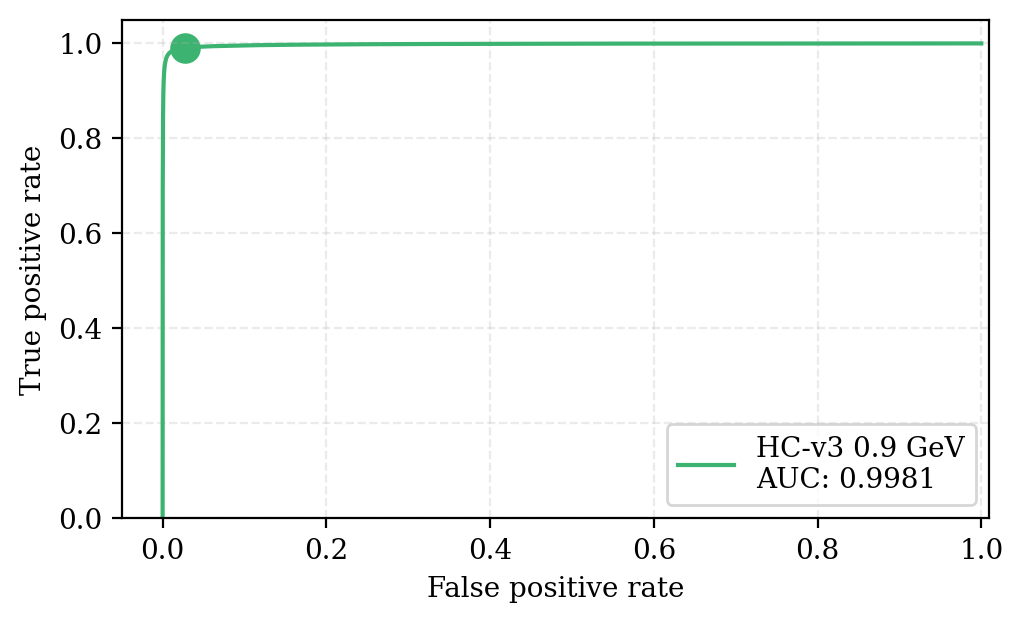

In [14]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
for name, (hits, targets, parts, metrics) in filtering_results.items():
    ax.plot(metrics["roc_fpr"], metrics["roc_tpr"], 
            color=training_colours[name], 
            label="%s %s\nAUC: %.4f"%(filtering_configs[name]["name"], name, metrics["roc_fpr_tpr_auc"])
           )
    #opt_thresh_label = "Opt. thr.: %.2f"%(filter_threshold)
    thid = np.argmin(np.abs(metrics["roc_fpr_tpr_thr"] - 0.1))
    ax.scatter(metrics["roc_fpr"][thid], metrics["roc_tpr"][thid],
               color=training_colours[name], s=100)#, label=opt_thresh_label)
    
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_xlim(-0.05,1.01)
ax.set_ylim(0.0, 1.05)
ax.grid(which="both")
ax.grid(zorder=0, alpha=0.25, linestyle="--")
ax.grid(zorder=0, alpha=0.25, linestyle="--")
ax.legend()

### Efficiency purity plot

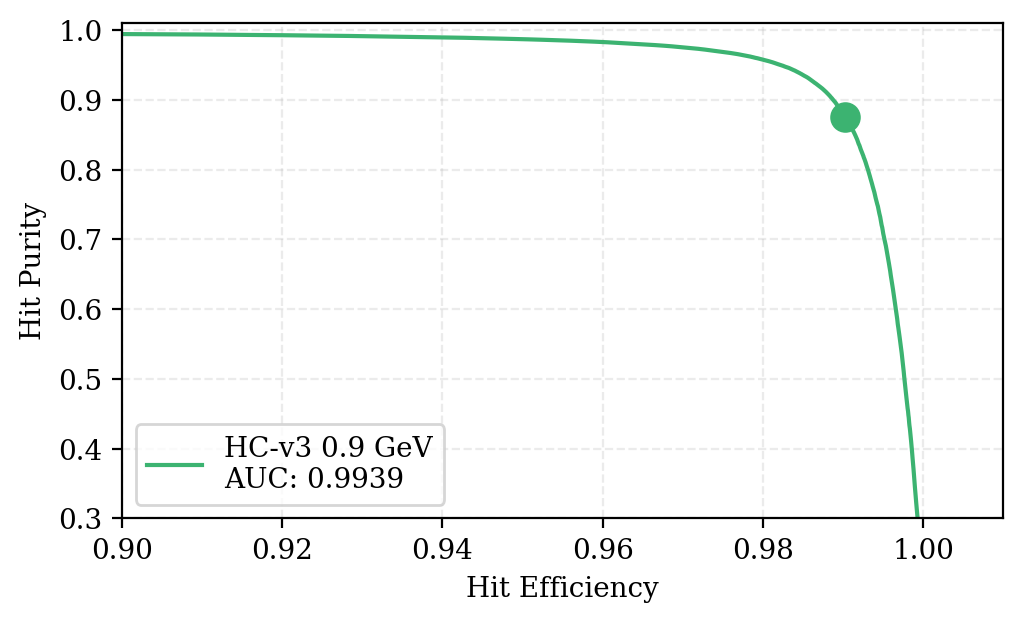

In [15]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
for name, (hits, targets, parts, metrics) in filtering_results.items():
    ax.plot(metrics["roc_eff"], metrics["roc_pur"], 
            color=training_colours[name], 
            label="%s %s\nAUC: %.4f"%(filtering_configs[name]["name"], name, metrics["roc_eff_pur_auc"])
           )
    #opt_thresh_label = "Opt. thr.: %.2f"%(filter_threshold)
    thid = np.argmin(np.abs(metrics["roc_eff_pur_thr"] - 0.1))
    ax.scatter(metrics["roc_eff"][thid], metrics["roc_pur"][thid],
               color=training_colours[name], s=100)#, label=opt_thresh_label)
    
ax.set_xlabel("Hit Efficiency")
ax.set_ylabel("Hit Purity")
ax.set_xlim(0.9,1.01)
ax.set_ylim(0.3, 1.01)
ax.grid(which="both")
ax.grid(zorder=0, alpha=0.25, linestyle="--")
ax.grid(zorder=0, alpha=0.25, linestyle="--")
ax.legend()


### Particle efficiency ($p_\mathrm{T}$ binned)

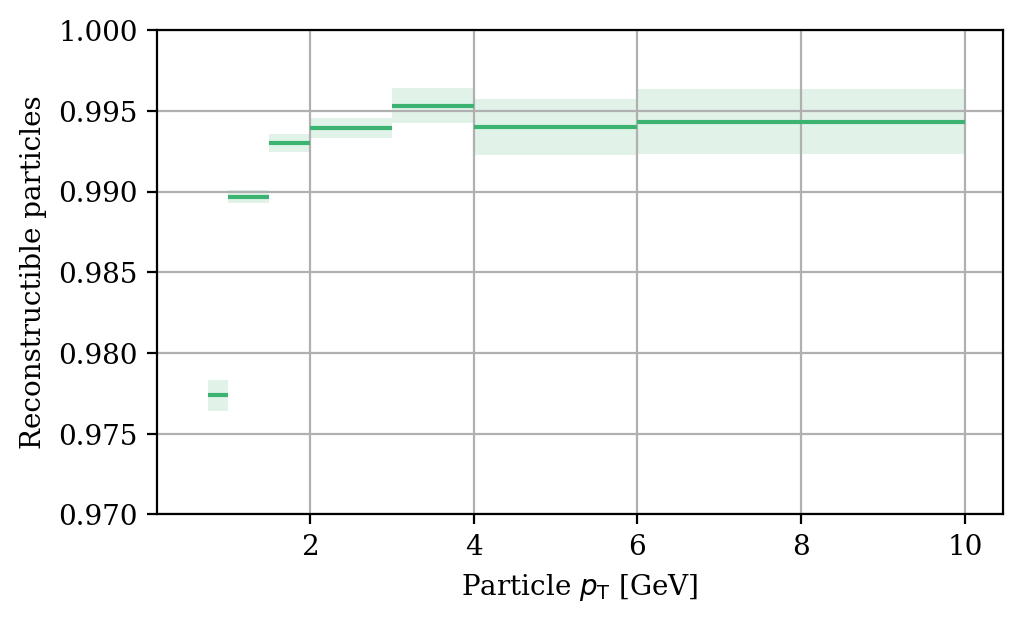

In [16]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
for name, (hits, targets, parts, metrics) in filtering_results.items():
    reconstructible = np.where(parts["pred_hits"] >= 3, True, False) # reconstructible particles must have >=3 hits
    reconstructible = reconstructible & parts["valid"] # apply valid_particle selection
    valid = ~np.isnan(parts["particle_pt"]) # remove excess entries (particles in event less than n_max_particles)
    bin_count, bin_error = binned(reconstructible[valid], parts["particle_pt"][valid], qty_bins["pt"])
    profile_plot(bin_count, bin_error, qty_bins["pt"], axes=ax, color=training_colours["0.9 GeV"])
    ax.set_xlabel(r'Particle $%s$ %s'%(qty_symbols["pt"], qty_units["pt"]))
    ax.set_ylabel('Reconstructible particles')
    ax.set_ylim(0.97,1)
    ax.set_xticks(np.arange(start=2, stop=11, step=2))
    ax.grid(which='both')
    plt.show()

### Combined plot

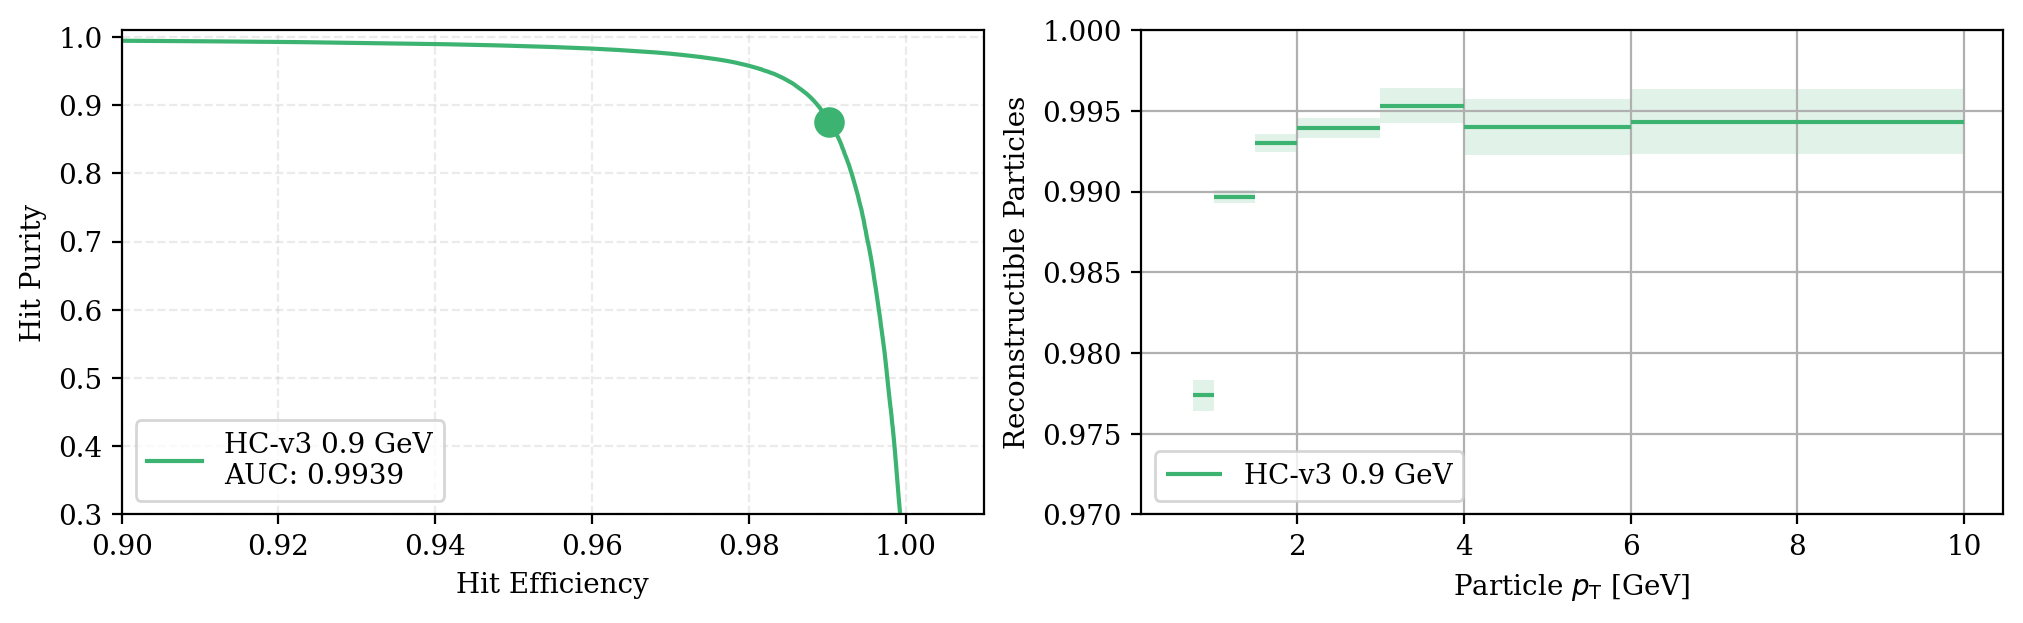

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10,3), constrained_layout=True)
for name, (hits, targets, parts, metrics) in filtering_results.items():
    ax[0].plot(metrics["roc_eff"], metrics["roc_pur"], 
            color=training_colours[name], 
            label="%s %s\nAUC: %.4f"%(filtering_configs[name]["name"], name, metrics["roc_eff_pur_auc"])
           )
    #opt_thresh_label = "Opt. thr.: %.2f"%(filter_threshold)
    thid = np.argmin(np.abs(metrics["roc_eff_pur_thr"] - 0.1))
    ax[0].scatter(metrics["roc_eff"][thid], metrics["roc_pur"][thid],
                  color=training_colours[name], s=100)#, label=opt_thresh_label)
    
    ax[0].set_xlabel("Hit Efficiency")
    ax[0].set_ylabel("Hit Purity")
    ax[0].set_xlim(0.9,1.01)
    ax[0].set_ylim(0.3, 1.01)
    ax[0].grid(which="both")
    ax[0].grid(zorder=0, alpha=0.25, linestyle="--")
    ax[0].grid(zorder=0, alpha=0.25, linestyle="--")
    ax[0].legend(loc=3)
    
    reconstructible = np.where(parts["pred_hits"] >= 3, True, False) # reconstructible particles must have >=3 hits
    reconstructible = reconstructible & parts["valid"] # apply valid_particle selection
    valid = ~np.isnan(parts["particle_pt"]) # remove excess entries (particles in event less than n_max_particles)
    bin_count, bin_error = binned(reconstructible[valid], parts["particle_pt"][valid], qty_bins["pt"])
    profile_plot(bin_count, bin_error, qty_bins["pt"], axes=ax[1], color=training_colours["0.9 GeV"], label="%s %s"%(filtering_configs[name]["name"], name))
    ax[1].set_xlabel(r'Particle $%s$ %s'%(qty_symbols["pt"], qty_units["pt"]))
    ax[1].set_ylabel('Reconstructible Particles')
    ax[1].set_ylim(0.97,1)
    ax[1].set_xticks(np.arange(start=2, stop=11, step=2))
    ax[1].grid(which='both')
    ax[1].legend(loc=3)
plt.show()